In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

In [2]:
df_monthly = pd.read_csv('Assignment-monthlyexcerpt.csv')
df_daily = pd.read_csv('Assignment-dailyexcerpt.csv')

C:\Users\A1857\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0,1,3,4,6,7,9,10,12,13,15,16,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_daily.drop(['Unnamed: 2','Unnamed: 5','Unnamed: 8','Unnamed: 11','Unnamed: 14','Unnamed: 17','Unnamed: 20'],axis=1,inplace=True)

In [4]:
for i in range(0,df_daily.columns.shape[0],2):
    
    df_ = df_daily.iloc[:,i:i+2].dropna()
    df_ = df_.drop(0)
    
    df_.columns = ['date',df_.columns[0]]
    df_.date = pd.to_datetime(df_.date,format='%d-%m-%y')
    df_ = df_.set_index('date')
    df_.iloc[:,0] = pd.to_numeric(df_.iloc[:,0])
    df_ = df_.rename(columns={df_.columns[0]:df_.columns[0].lower().replace(' ','_').replace('/','_')})
    df_ = df_.asfreq('D')

    df_.to_csv('clean_data/{}_daily.csv'.format(df_.columns[0]))

In [5]:
list(filter(lambda x:'daily' in x,os.listdir('clean_data/')))

['bo1_comb_comdty_daily.csv',
 'co1_comb_comdty_daily.csv',
 'fbmklci_index_daily.csv',
 'klpln_index_daily.csv',
 'pal2maly_index_daily.csv',
 'qs1_comdty_daily.csv',
 'usdmyr_curncy_daily.csv']

In [6]:
df_bo1_comb = pd.read_csv('clean_data/bo1_comb_comdty_daily.csv',index_col=0)
df_co1_comb = pd.read_csv('clean_data/co1_comb_comdty_daily.csv',index_col=0)
df_fbmklci = pd.read_csv('clean_data/fbmklci_index_daily.csv',index_col=0)
df_klpln = pd.read_csv('clean_data/klpln_index_daily.csv',index_col=0)
df_palm_oil = pd.read_csv('clean_data/pal2maly_index_daily.csv',index_col=0)
df_qs1 = pd.read_csv('clean_data/qs1_comdty_daily.csv',index_col=0)
df_usdmyr = pd.read_csv('clean_data/usdmyr_curncy_daily.csv',index_col=0)

df = df_bo1_comb.join(df_co1_comb).join(df_fbmklci).join(df_klpln).join(df_qs1).join(df_usdmyr).join(df_palm_oil)

In [8]:
df.isnull().sum()

bo1_comb_comdty    1468
co1_comb_comdty    1395
fbmklci_index      1543
klpln_index        1543
qs1_comdty         1397
usdmyr_curncy      1375
pal2maly_index     1579
dtype: int64

In [9]:
df = df.asfreq('D').asfreq('B') ## Convert data to weekday frequency (Mon - Friday)

In [10]:
for column in df.columns:
    
    df.loc[:,column] = df.loc[:,column].fillna(method='ffill')

In [11]:
df.head()

,bo1_comb_comdty,co1_comb_comdty,fbmklci_index,klpln_index,qs1_comdty,usdmyr_curncy,pal2maly_index
date,,,,,,,
2005-01-03,20.0,NaN,903.8,2419.3,NaN,3.8,1389.0
2005-01-04,20.0,41.04,902.5,2415.1,364.25,3.8,1368.0
2005-01-05,20.1,40.51,908.0,2400.5,358.25,3.8,1364.0
2005-01-06,20.2,42.85,910.4,2402.3,377.00,3.8,1368.0
2005-01-07,20.4,43.18,916.3,2416.9,376.25,3.8,1367.0


In [12]:
## Skip first week due to null value at first date

df = df.iloc[5:]

## Analysis

In [13]:
df_daily.columns

Index(['KLPLN Index', 'Unnamed: 1', 'FBMKLCI Index', 'Unnamed: 4',
       'PAL2MALY Index', 'Unnamed: 7', 'BO1 COMB Comdty', 'Unnamed: 10',
       'USDMYR Curncy', 'Unnamed: 13', 'CO1 COMB Comdty', 'Unnamed: 16',
       'QS1 Comdty', 'Unnamed: 19'],
      dtype='object')

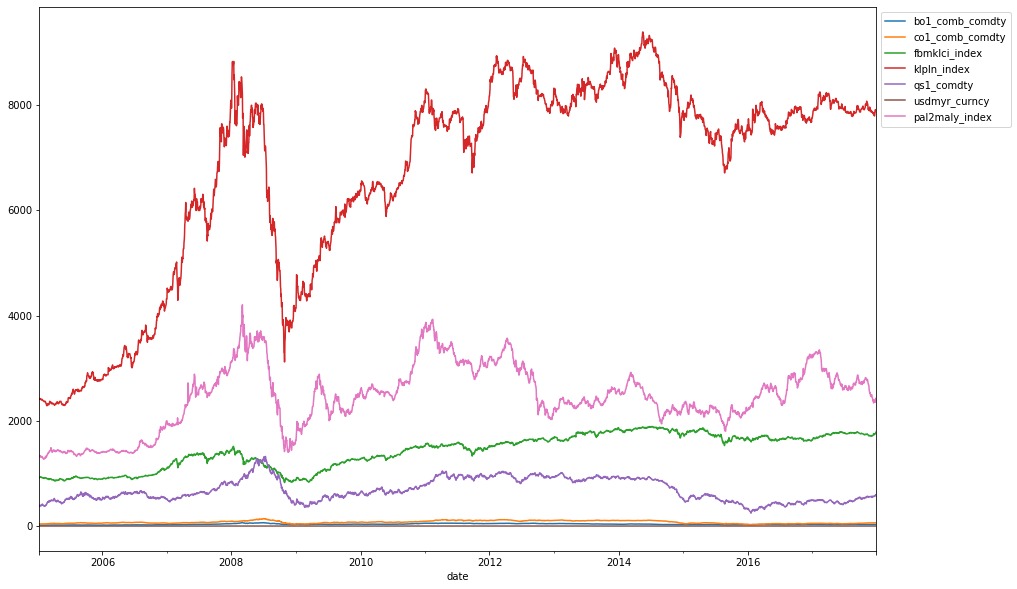

In [14]:
fig,ax = plt.subplots(figsize=(15,10))
df.plot(ax=ax)
plt.legend(bbox_to_anchor=(1,1))

[]

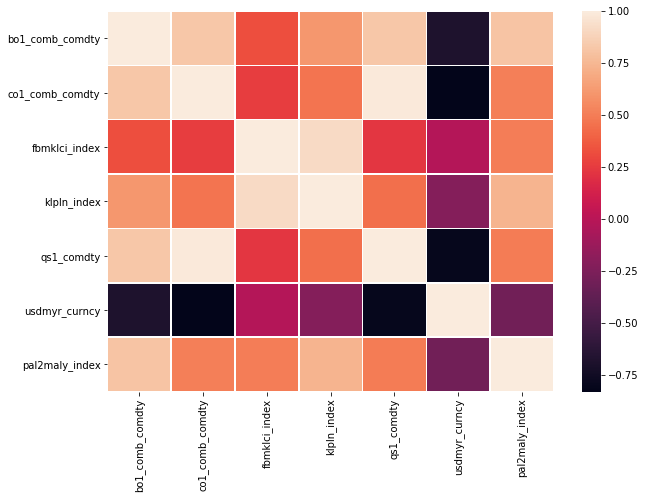

In [15]:
# Correlation between features
fig,ax = plt.subplots(figsize=(10,7))
sns.heatmap(df.corr(),linewidths=.5).plot(ax=ax)


In [16]:
df_daily.columns

Index(['KLPLN Index', 'Unnamed: 1', 'FBMKLCI Index', 'Unnamed: 4',
       'PAL2MALY Index', 'Unnamed: 7', 'BO1 COMB Comdty', 'Unnamed: 10',
       'USDMYR Curncy', 'Unnamed: 13', 'CO1 COMB Comdty', 'Unnamed: 16',
       'QS1 Comdty', 'Unnamed: 19'],
      dtype='object')

In [17]:
df.columns

Index(['bo1_comb_comdty', 'co1_comb_comdty', 'fbmklci_index', 'klpln_index',
       'qs1_comdty', 'usdmyr_curncy', 'pal2maly_index'],
      dtype='object')

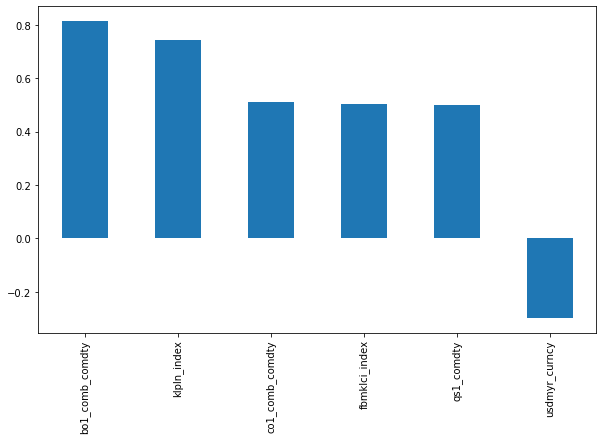

In [18]:
## Correlation other features with palm oil
fig, ax = plt.subplots(figsize=(10,6))
df.corr().loc['pal2maly_index'].drop('pal2maly_index').sort_values(ascending=False).plot(kind='bar',ax=ax)

## Multivariate Model

Let's do a different approach on the daily data, we will try to predict the next day value given the daily data. The feaures that used here will be the percentage difference between t and t-1.

In [19]:
from sklearn.model_selection import train_test_split,GridSearchCV
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import precision_score,recall_score,confusion_matrix

In [20]:
df_train = df.loc[df.index < '2016-01-04']
df_test = df.loc[df.index >= '2016-01-04']

In [21]:
X_y_train = df_train.pct_change().dropna()

In [22]:
df_validate = df_test.pct_change().dropna()
X_validate = df_validate.iloc[:,:-1]
y_validate = df_validate.iloc[:,-1] 

In [23]:
# Add day coulumn
X_y_train['day'] = X_y_train.index.map(lambda x:x.strftime("%A"))
X_y_train = X_y_train.join(pd.get_dummies(X_y_train.day)).drop('day',axis=1)

X_validate['day'] = X_validate.index.map(lambda x:x.strftime("%A"))
X_validate = X_validate.join(pd.get_dummies(X_validate.day)).drop('day',axis=1)

In [24]:
X_y_train.head()

,bo1_comb_comdty,co1_comb_comdty,fbmklci_index,klpln_index,qs1_comdty,usdmyr_curncy,pal2maly_index,Friday,Monday,Thursday,Tuesday,Wednesday
date,,,,,,,,,,,,
2005-01-11,-0.014778,0.004660,0.012622,0.002851,-0.036099,0.0,-0.006716,0,0,0,1,0
2005-01-12,-0.015000,0.012987,0.002901,-0.003337,-0.015112,0.0,-0.010518,0,0,0,0,1
2005-01-13,0.020305,0.035027,0.000857,0.002191,0.056037,0.0,0.004556,0,0,1,0,0
2005-01-14,-0.024876,-0.001327,-0.004710,-0.004166,0.001263,0.0,0.010582,1,0,0,0,0
2005-01-17,0.000000,-0.002658,0.002797,0.002817,0.005678,0.0,-0.010471,0,1,0,0,0


In [45]:
X_train,X_test,y_train,y_test = train_test_split(X_y_train.drop('pal2maly_index',axis=1),X_y_train.loc[:,'pal2maly_index'],
                                                 test_size=0.20,random_state=0)


In [47]:
pipe = Pipeline([("Regressor", RandomForestRegressor())])
# Hyperparameter grid search 
grid_param = [
                {"Regressor": [RandomForestRegressor(random_state=0,n_jobs=-1)],
                 "Regressor__n_estimators": [10,50, 100,200,500,1000],
                 "Regressor__max_depth":[2,4,8,None]
                },
                {"Regressor": [xgb.XGBRegressor(objective ='reg:squarederror')],
                 "Regressor__n_estimators": [10,50, 100,200,500,1000],
                 "Regressor__learning_rate":[0.01,0.1],
                 "Regressor__max_depth":[2,4,8,None]
                }]

In [48]:
gridsearch = GridSearchCV(pipe, grid_param, cv=10, verbose=0,n_jobs=-1) # Fit grid search
best_model = gridsearch.fit(X_train,y_train)

In [49]:
best_model.best_estimator_

Pipeline(memory=None,
         steps=[('Regressor',
                 XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
                              colsample_bynode=1, colsample_bytree=1, gamma=0,
                              gpu_id=-1, importance_type='gain',
                              interaction_constraints=None, learning_rate=0.1,
                              max_delta_step=0, max_depth=2, min_child_weight=1,
                              missing=nan, monotone_constraints=None,
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                              objective='reg:squarederror', random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method=None,
                              validate_parameters=False, verbosity=None))],
         verbose=False)

In [51]:
y_boolean = (y_test > 0).to_frame()

In [52]:
y_boolean['predict'] = best_model.predict(X_test)

In [53]:
y_boolean.predict = (y_boolean.predict > 0)

In [54]:
##

confusion_matrix(y_boolean.iloc[:,0],y_boolean.iloc[:,1])

array([[137, 139],
       [ 84, 213]], dtype=int64)

In [55]:
precision_score(y_boolean.iloc[:,0],y_boolean.iloc[:,1])

0.6051136363636364

In [56]:
recall_score(y_boolean.iloc[:,0],y_boolean.iloc[:,1])

0.7171717171717171

In [27]:
best_model = RandomForestRegressor(n_estimators=1000, max_depth=8,n_jobs=-1,random_state=0)

In [57]:
gridsearch = GridSearchCV(pipe, grid_param, cv=10, verbose=0,n_jobs=-1) # Fit grid search
best_model = gridsearch.fit(X_y_train.drop('pal2maly_index',axis=1),X_y_train.loc[:,'pal2maly_index'])

In [31]:
predict = best_model.predict(X_validate)

In [36]:
y_validate_boolean = (y_validate > 0).to_frame()

In [39]:
y_validate_boolean['predict'] = predict

In [41]:
y_validate_boolean.predict = y_validate_boolean.predict > 0

In [43]:
confusion_matrix(y_validate_boolean.iloc[:,0],y_validate_boolean.iloc[:,1])

array([[127, 149],
       [ 78, 165]], dtype=int64)

In [44]:
precision_score(y_validate_boolean.iloc[:,0],y_validate_boolean.iloc[:,1])

0.5254777070063694